# Transfer learning for Speech Emotion Recognition on Serbian acted speech

In this notebook, we evaluate a pretrained audio emotion recognition model on a newly collected
Serbian acted speech dataset. The experiments are conducted in three stages:

1. Baseline evaluation of the pretrained model on two unseen Serbian speakers.
2. Fine-tuning the model using the remaining Serbian speakers.
3. Re-evaluation on both Serbian and original English test sets.

Only the audio modality is considered, as the textual content is not correlated with emotion.


## Setup

In [1]:
# System setup and dependencies

!sudo apt-get update
!sudo apt-get install ffmpeg
!pip install torch==2.9.0 torchvision==0.24.0 torchaudio==2.9.0 --index-url https://download.pytorch.org/whl/cu126

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://cli.github.com/packages stable/main amd64 Packages [356 B]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [83.8 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,339 kB]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:13 https://ppa.launchpadcontent.

In [2]:
# Additional Python packages for AI/Audio/NLP

!pip -q install transformers datasets accelerate sentencepiece

!pip install -q librosa soundfile

!pip install torchcodec==0.8.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.5 MB/s eta 0:00:00


In [3]:
import os
import random
from pathlib import Path
import numpy as np
import pandas as pd
import librosa

import torch
import torchaudio
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

from transformers import Wav2Vec2Processor, Wav2Vec2Model

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import ConfusionMatrixDisplay


In [4]:
# Google Drive is used to store the MELD dataset and to save the processed audio embeddings.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Config

In [5]:
CONFIG = {
    # ========= DEVICE =========
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),

    # ========= PATHS =========
    "seac_root": Path("/content/drive/MyDrive/datasets/data_mono"),
    "meld_checkpoint": Path("/content/drive/MyDrive/models/checkpoints/audio_best.pt"),

    # ========= DATA =========
    "sample_rate": 16000,
    "max_audio_length": 4.0,

    # ===== EMOTIONS (APH–SEAC) =====
    "seac_emotion_map": {
        "0": "anger",
        "1": "neutral",
        "2": "happiness",
        "3": "fear",
        "4": "sadness",
    },

   # Normalize SEAC → canonical names (MELD-style)
    "emotion_normalization": {
        "happiness": "joy",
        "neutral": "neutral",
        "anger": "anger",
        "sadness": "sadness",
        "fear": "fear",
    },

    # MELD label mapping
    "meld_label_map": {
        "neutral": 0,
        "joy": 1,
        "anger": 3,
        "sadness": 4,
        "fear": 5,
    },

    # ========= Speakers =========
    "selected_speakers": {
        "0005":"female",
        "1005":"male",
    },

    # Model
    "audio_embedding_dim": 768,
    "num_classes": 7,
    "dropout": 0.3,


    # ========= TRAINING =========
    "batch_size": 16,
    "lr_finetune": 1e-4,
    "num_epochs": 30,
    "early_stopping_patience": 5,

    # ========= REPRODUCIBILITY =========
    "seed": 42,
}


In [6]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(CONFIG["seed"])


In [7]:
label_id_to_name = {
    0: "neutral",
    1: "joy",
    2: "surprise",
    3: "anger",
    4: "sadness",
    5: "fear",
    6: "disgust"
}

## SEAC  Dataset

The SEAC dataset consists of emotionally expressive speech recordings in Serbian, organized hierarchically by speakers and emotion categories. Each speaker is represented by a separate directory containing multiple subfolders, where each subfolder corresponds to a specific emotion and includes several .wav audio files.

For the experiments in this work, a subset of the SEAC dataset is used, defined by a selected set of speakers.

Audio samples are loaded by iterating over the selected speakers and their emotion-specific subfolders. Emotion labels are first normalized and then mapped to the MELD emotion label space in order to ensure label consistency across datasets. Each sample is stored together with its audio path, normalized emotion, numerical class label, and speaker identifier.

To enable model evaluation, a custom PyTorch dataset is defined for audio processing. All audio signals are converted to mono, resampled to 16 kHz, and truncated to a fixed maximum duration. The test set consists of all loaded SEAC samples and is evaluated using a DataLoader with a batch size of one, allowing sample-level analysis.

In [8]:
def load_seac_samples(config):
    samples = []

    for speaker_id in config["selected_speakers"]:
        speaker_path = config["seac_root"] / speaker_id

        for folder_id, emotion in config["seac_emotion_map"].items():
            emotion_path = speaker_path / folder_id
            if not emotion_path.exists():
                continue

            for wav in emotion_path.glob("*.wav"):

                # 1. normalize emotion name
                norm_emotion = config["emotion_normalization"][emotion]

                # 2. map to MELD label
                meld_label = config["meld_label_map"][norm_emotion]

                samples.append({
                    "audio_path": wav,
                    "emotion": norm_emotion,
                    "label": meld_label,
                    "speaker": speaker_id
                })

    return samples


In [9]:
def load_seac_samples(config, speakers):
    samples = []

    for speaker_id in speakers:
        speaker_path = config["seac_root"] / speaker_id

        for folder_id, emotion in config["seac_emotion_map"].items():
            emotion_path = speaker_path / folder_id
            if not emotion_path.exists():
                continue

            for wav in emotion_path.glob("*.wav"):

                # 1. normalize emotion name
                norm_emotion = config["emotion_normalization"][emotion]

                # 2. map to MELD label
                meld_label = config["meld_label_map"][norm_emotion]

                samples.append({
                    "audio_path": wav,
                    "emotion": norm_emotion,
                    "label": meld_label,
                    "speaker": speaker_id
                })

    return samples


In [10]:
class SEACAudioDataset(Dataset):
    def __init__(self, samples, sample_rate=16000, max_len=4.0):
        self.samples = samples
        self.sample_rate = sample_rate
        self.max_len = int(sample_rate * max_len)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]

        waveform, sr = torchaudio.load(path)
        waveform = waveform.mean(dim=0)  # mono

        if sr != self.sample_rate:
            waveform = torchaudio.functional.resample(
                waveform, sr, self.sample_rate
            )

        waveform = waveform[: self.max_len]

        return waveform, label

In [11]:
class SEACAudioDataset(Dataset):
    def __init__(self, samples, sample_rate=16000, max_len=4.0):
        self.samples = samples
        self.sample_rate = sample_rate
        self.max_len = int(sample_rate * max_len)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        path = sample["audio_path"]
        label = sample["label"]

        try:
            waveform, sr = torchaudio.load(path)

            if sr != self.sample_rate:
                waveform = torchaudio.functional.resample(waveform, sr, self.sample_rate)

            waveform = waveform.squeeze(0)

            if waveform.shape[0] > self.max_len:
                waveform = waveform[:self.max_len]
            else:
                pad = self.max_len - waveform.shape[0]
                waveform = torch.nn.functional.pad(waveform, (0, pad))

        except Exception:
            waveform = torch.zeros(self.max_len, dtype=torch.float32)

        return waveform, label


In [12]:
def build_audio_loader(
    samples,
    config,
    batch_size,
    shuffle,
    collate_fn=None
):
    dataset = SEACAudioDataset(
        samples,
        sample_rate=config["sample_rate"],
        max_len=config["max_audio_length"]
    )

    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=collate_fn
    )


In [13]:
def audio_collate_fn(batch):
    waveforms, labels = zip(*batch)

    waveforms = [
        torch.tensor(w, dtype=torch.float32)
        if not torch.is_tensor(w) else w
        for w in waveforms
    ]

    waveforms = torch.nn.utils.rnn.pad_sequence(
        waveforms,
        batch_first=True
    )

    labels = torch.tensor(labels, dtype=torch.long)

    return waveforms, labels

In [16]:
samples_step1 = load_seac_samples(CONFIG,CONFIG["selected_speakers"])
print(f"Loaded {len(samples_step1)} SEAC test samples")

from collections import Counter
print(Counter([s["label"] for s in samples_step1]))
print(Counter([s["emotion"] for s in samples_step1]))


Loaded 598 SEAC test samples
Counter({0: 122, 5: 122, 4: 122, 3: 116, 1: 116})
Counter({'neutral': 122, 'fear': 122, 'sadness': 122, 'anger': 116, 'joy': 116})


In [17]:
test_loader = build_audio_loader(
    samples=samples_step1,
    config=CONFIG,
    batch_size=1,
    shuffle=False
)

## Audio Feature Extraction

A pre-trained Wav2Vec 2.0 base model is used to extract audio embeddings from raw waveforms.
The model is initialized with pre-trained weights and used in evaluation mode.


In [ ]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
wav2vec = Wav2Vec2Model.from_pretrained(
    "facebook/wav2vec2-base"
).to(CONFIG["device"])
wav2vec.eval()

/usr/local/lib/python3.12/dist-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

## Audio Classifier

A feed-forward neural network is used to classify audio embeddings extracted by Wav2Vec 2.0.
The network consists of two linear layers with a 256-dimensional hidden layer, ReLU activation, and dropout regularization.

In [ ]:
class AudioClassifier(nn.Module):
    def __init__(self, config):
        super(AudioClassifier, self).__init__()

        self.classifier = nn.Sequential(
            nn.Linear(config["audio_embedding_dim"], 256),
            nn.ReLU(),
            nn.Dropout(config["dropout"]),
            nn.Linear(256, config["num_classes"])
        )

    def forward(self, audio_emb):
        return self.classifier(audio_emb)

## Loading model

In [ ]:
checkpoint = torch.load(
    CONFIG["meld_checkpoint"],
    map_location=CONFIG["device"]
)

audio_model = AudioClassifier(CONFIG).to(CONFIG["device"])
audio_model.load_state_dict(checkpoint["model_state"], strict=True)
audio_model.eval()

AudioClassifier(
  (classifier): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=7, bias=True)
  )
)

## Prediction Distribution Analysis

The trained audio model is evaluated on the SEAC test set using the MELD emotion label space.
For each test sample, audio embeddings are extracted with the pre-trained Wav2Vec 2.0 encoder and classified using the audio classification head.

To analyze model behavior beyond standard performance metrics, the distributions of true and predicted labels are computed.
This analysis provides insight into potential class imbalance effects and model bias by comparing the ground-truth label distribution with the distribution of model predictions.


In [ ]:
from collections import Counter

pred_counter = Counter()
target_counter = Counter()

all_preds = []
all_targets = []

with torch.no_grad():
    for waveforms, meld_labels in test_loader:

        waveforms = waveforms.to(CONFIG["device"])
        meld_labels = meld_labels.to(CONFIG["device"])

        encoder_outputs = wav2vec(waveforms)
        audio_emb = encoder_outputs.last_hidden_state.mean(dim=1)

        logits = audio_model(audio_emb)
        preds = torch.argmax(logits, dim=1)

        for t, p in zip(meld_labels, preds):
            all_targets.append(int(t))
            all_preds.append(int(p))

            target_counter[int(t)] += 1
            pred_counter[int(p)] += 1

In [ ]:
inv_meld = {v: k for k, v in CONFIG["meld_label_map"].items()}

print("Distribution of TRUE labels (MELD):")
for k, v in sorted(target_counter.items()):
    print(f"  {inv_meld.get(k, 'UNK')} ({k}): {v}")

print("\nDistribution of PREDICTED labels:")
for k, v in sorted(pred_counter.items()):
    print(f"  {inv_meld.get(k, 'UNK')} ({k}): {v}")

Distribution of TRUE labels (MELD):
  neutral (0): 122
  joy (1): 116
  anger (3): 116
  sadness (4): 122
  fear (5): 122

Distribution of PREDICTED labels:
  neutral (0): 598


## Quantitative Evaluation and Error Analysis

Evaluation results show low overall performance of the audio-only model, with particularly poor class-wise discrimination.
The confusion matrix and per-class F1-scores reveal a strong bias toward a single predicted class, indicating a collapse in model predictions and motivating further improvements in model design.


In [ ]:
def plot_confusion_matrix_with_percentages(
    y_true,
    y_pred,
    class_names,
    title="Confusion Matrix",
    figsize=(8, 6),
    cmap="Blues"
):
    cm = confusion_matrix(y_true, y_pred)

    # Row-wise percentages
    cm_percent = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100

    # Create annotation labels
    annotations = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annotations[i, j] = f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)"

    plt.figure(figsize=figsize)
    sns.heatmap(
        cm,
        annot=annotations,
        fmt="",
        cmap=cmap,
        xticklabels=class_names,
        yticklabels=class_names,
        square=True
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(title + " (Counts + Row %)")
    plt.tight_layout()
    plt.show()

In [ ]:
# Plots per-class F1-scores as a bar chart.
def plot_per_class_f1(
    y_true,
    y_pred,
    class_names,
    title="Per-class F1-score",
    figsize=(8, 5),
    ylim=(0.0, 1.0)
):

    precision, recall, f1, support = precision_recall_fscore_support(
        y_true,
        y_pred,
        labels=range(len(class_names)),
        average=None
    )

    x = np.arange(len(class_names))

    plt.figure(figsize=figsize)
    bars = plt.bar(x, f1)

    plt.xticks(x, class_names, rotation=45, ha="right")
    plt.ylabel("F1-score")
    plt.ylim(ylim)
    plt.title(title)

    # Annotate bars with values
    for bar, score in zip(bars, f1):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.01,
            f"{score:.2f}",
            ha="center",
            va="bottom",
            fontsize=9
        )

    plt.tight_layout()
    plt.show()

In [ ]:
acc = accuracy_score(all_targets, all_preds)
f1 = f1_score(all_targets, all_preds, average="weighted")
cm = confusion_matrix(all_targets, all_preds)

print(f"SEAC → MELD Audio-only results")
print(f"Accuracy: {acc:.4f}")
print(f"Weighted F1: {f1:.4f}")
print("Confusion matrix:")
print(cm)

SEAC → MELD Audio-only results
Accuracy: 0.2040
Weighted F1: 0.0691
Confusion matrix:
[[122   0   0   0   0]
 [116   0   0   0   0]
 [116   0   0   0   0]
 [122   0   0   0   0]
 [122   0   0   0   0]]


In [ ]:
y_true = np.array(all_targets)
y_pred = np.array(all_preds)

The confusion matrix shows that the model predicts all samples as *neutral*, regardless of the true label.
This indicates a complete lack of class discrimination and a strong prediction bias.


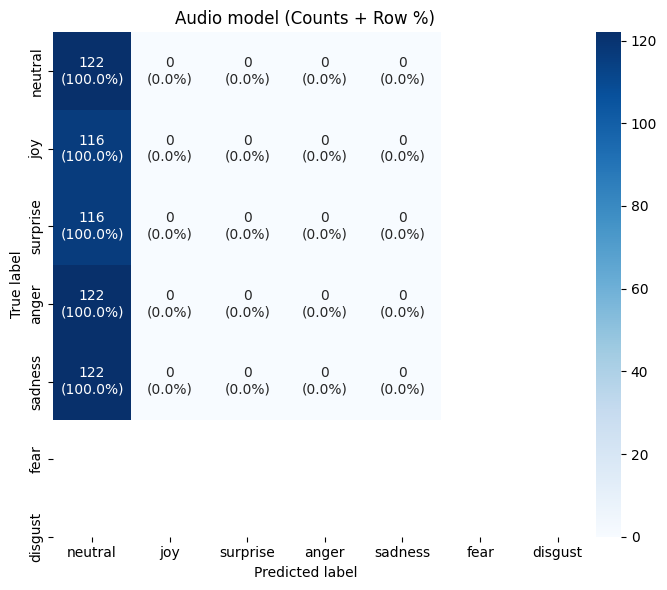

In [ ]:
plot_confusion_matrix_with_percentages(
    y_true,
    y_pred,
    class_names=emotion_labels,
    title="Audio model"
)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


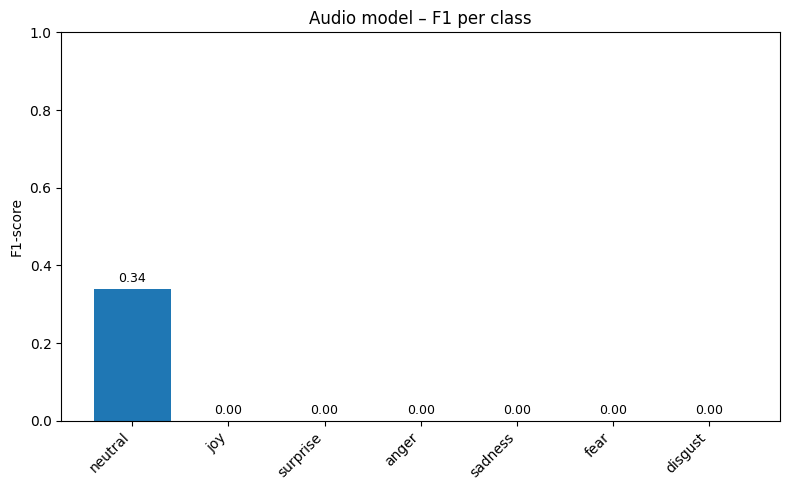

In [ ]:
plot_per_class_f1(
    y_true,
    y_pred,
    class_names=emotion_labels,
    title="Audio model – F1 per class"
)

